**Brian Blaylock**  
**June 6, 2019**

# How GLM events, groups, and flashes are related.

Each GLM file contains observations for a 20 second chunk of time. That data is separated into events, groups, and flashes. Events are the pixel element of observed lightning activity. The Lightning Filter Cluster Algorithm then creates groups and flashes that are related.

The following details are taken from the paper:

> Goodman, S. and coauthors, 2013: The GOES-R Geostationary Lightning Mapper (GLM). Atmospheric Research, 125-126, 34-49, https://doi.org/10.1016/j.atmosres.2013.01.006

- **Event**: "Occurrence of a single pixel exceeding the background threshold during a single frame." A frame durration is 2 ms. It can be interpreted as a single optical pulse due to lightning, but multiple pulses can contribute to an event in the 2 ms. An event is the most basic unit of data obtained from the instrument.
- **Group**: Lightning will often illuminate more than one pixel at a time. A group is 2 or more adjacent events or pixels triggered by the lightning within the same frame.
- **Flash**: Flashes are groups that occur within 0.33 seconds of each other and are no more than 16.5 km (~2 pixels) apart. A flash can be as few as one group with one event, or many groups with many events. Flashes should usually coorespond to a "lightning flash." The location of a Flash is the centroid of the events weighted by optical energy (illumination??).

In [652]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

from fires_list import get_fire

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, get_hrrr_latlon
from BB_GOES.get_GOES import get_GOES_nearesttime
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST, filter_by_HRRR
from BB_maps.my_basemap import draw_centermap, draw_HRRR_map

Get the info and data for the event we want to look at (Mallard Fire case). A GLM file contains Event, Group, and Flash data for 20 seconds of lightning observations.

In [20]:
EVENT = get_fire('Mallard')

FILE = get_GOES_nearesttime(EVENT['event'], product='GLM', satellite=16)
print(FILE)
x = xarray.open_dataset(FILE)

Requested 2018-05-16 02:00:00	satellite: GOES-16	Product: GLM
Looking here: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180516/01/
Looking here: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180516/02/
Looking here: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180516/03/
Nearest File: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180516/01/OR_GLM-L2-LCFA_G16_s20181360159400_e20181360200000_c20181360200029.nc
File DATETIME: 2018-05-16 02:00:00
/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180516/01/OR_GLM-L2-LCFA_G16_s20181360159400_e20181360200000_c20181360200029.nc


In [313]:
m = m = draw_centermap((EVENT['latitude'], EVENT['longitude']), size=(2.75, 2.75))

Plot each event, group, and flash on the map...

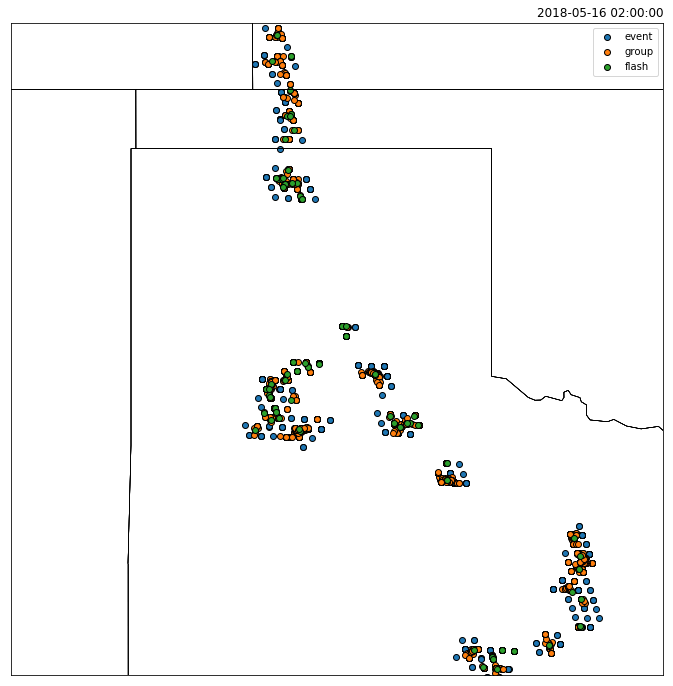

In [314]:
plt.figure(figsize=(12,12))

for d in ['event', 'group', 'flash']:
    m.scatter(x[d+'_lon'], x[d+'_lat'], latlon=True, edgecolor='k', label=d)
    m.drawstates()
    plt.legend();
    plt.title(EVENT['event'], loc='right');

---
The GLM CCD detector has a limited number of pixels. An "event" is when a pixel on the CCD observes a change in the background light.

Looking at the unique locations of each event, group, and flash reveals that the GLM events occur on a fixed grid while the groups and flashes are centroids locations, each with their own unique location.

In [311]:
for d in ['event', 'group', 'flash']:
    a = x[d+'_lon'].data
    b = x[d+'_lat'].data
    c = np.rot90(np.array([a,b]))
    unique = len(np.unique(c, axis=0))
    print('Unique %s: %s (%s total %s...%.1f%%)' % (d+'s', unique, len(a), d+'s', unique/len(a)*100))

Unique events: 2942 (50954 total events...5.8%)
Unique groups: 32100 (32511 total groups...98.7%)
Unique flashs: 782 (782 total flashs...100.0%)


In [398]:
def flash_idx_within_location(GLM, centerLON, centerLAT, within=3):
    """
    Retuns the flash index numbers for the flashes that occur near a center point
    
        GLM       - The GLM dataset opened with xarray
        centerLON - center longitude
        centerLAT - center latitude
        within    - boundary box in degrees
    """
    delta_lat = np.abs(GLM.flash_lat - centerLAT)
    delta_lon = np.abs(GLM.flash_lon - centerLON)
    c = np.maximum(delta_lon, delta_lat)
    return np.where(c < within)[0]

In [440]:
def events_in_group(GLM, group_idx):
    """
    GLM       - GLM file loaded with xarray
    group_idx - The group index for which you want all the events.
                NOTE: not the id, but the array index.
    """
    group_id = GLM.group_id[group_idx]
    return np.where(GLM.event_parent_group_id==group_id)[0]

def groups_in_flash(GLM, flash_idx):
    """
    GLM       - GLM file loaded with xarray
    flash_idx - The flash index for which you want all the groups.
                NOTE: not the id, but the array index.
    """
    flash_id = GLM.flash_id[flash_idx]
    return np.where(GLM.group_parent_flash_id==flash_id)[0]

def FGE_dict(EVENT, within=3):
    """A dictinary of flashes, groups, and event INDEX number"""
    flash_idx = flash_idx_within_location(x, EVENT['longitude'], EVENT['latitude'], within)
    
    FGE = {}
    for F in flash_idx:
        group_idx = groups_in_flash(x, F)
        FGE[F] = {}
        for G in group_idx:
            event_idx = events_in_group(x, G)
            FGE[F][G] = event_idx
    return FGE

Generate a heiarchy of Flash, Group, Events dictionary...

In [438]:
# Relation between Flash, Group, and Event INDEX numbers
FGE = FGE_dict(EVENT)

Plot each event (colored by number ov events in the 20 second data file), groups, and flash locations...

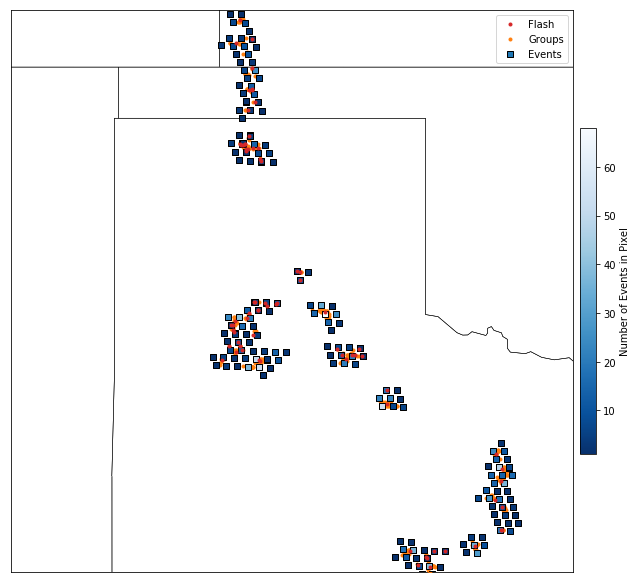

In [544]:
plt.figure(figsize=(12,12))

F = list(FGE.keys())
m.scatter(x.flash_lon[F], x.flash_lat[F], color='tab:red', marker='.', zorder=100, label='Flash')

G = np.array(list(itertools.chain(*[list(FGE[F].keys()) for F in FGE])))
m.scatter(x.group_lon[G], x.group_lat[G], color='tab:orange', marker='.', zorder=10, label='Groups')

E = np.array(list(itertools.chain(*[list(FGE[F][G]) for F in FGE for G in FGE[F]])))
#m.scatter(x.event_lon[E], x.event_lat[E], color='tab:blue', marker='s', zorder=15)
pairs = np.dstack([x.event_lon[E], x.event_lat[E]])[0]
unique, colors = np.unique(pairs, axis=0, return_counts=True)
m.scatter(unique[:,0], unique[:,1], c=colors, cmap='Blues_r', marker='s', edgecolor='k', zorder=15, label='Events')
plt.colorbar(shrink=0.5, pad=.01, label='Number of Events in Pixel')

m.drawstates()
plt.legend()

# Plot events and groups for a single flash
- **Flash**: Red dot
- **Group**: Orange circle
- **Event**: Blue Square

Lines draw from: **`Event --> Group --> Flash`**

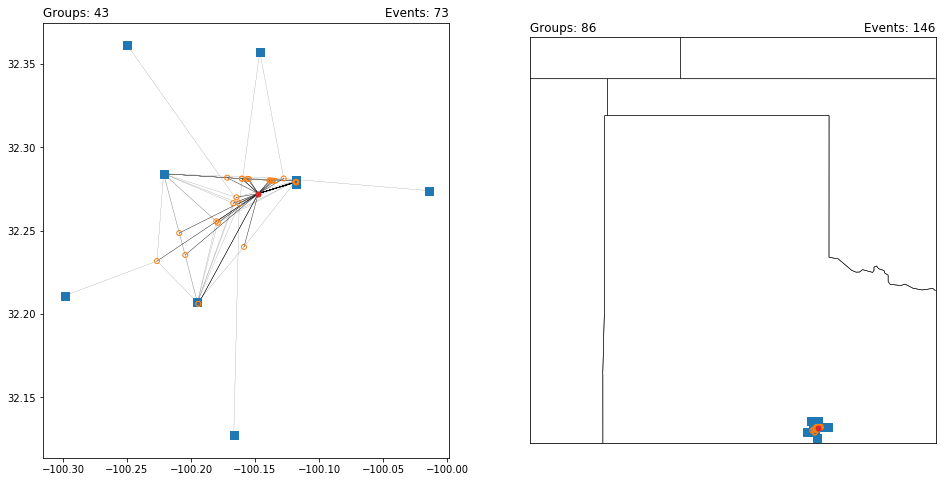

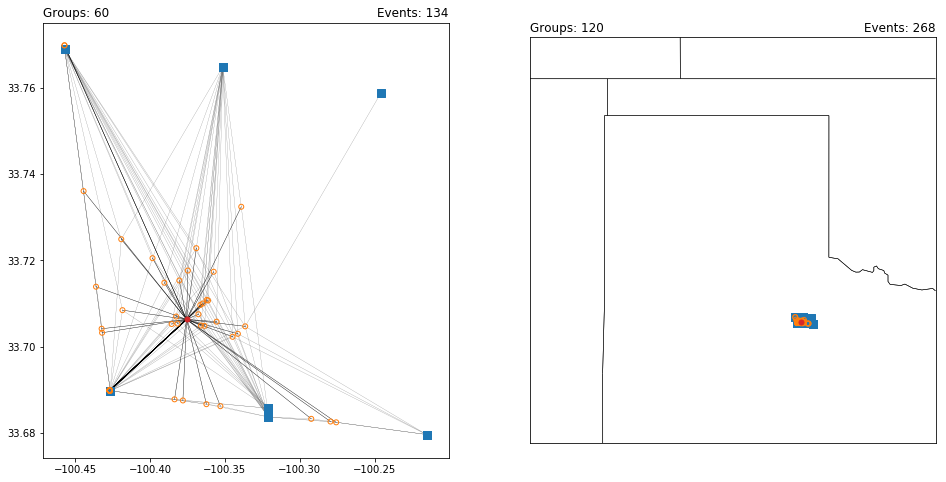

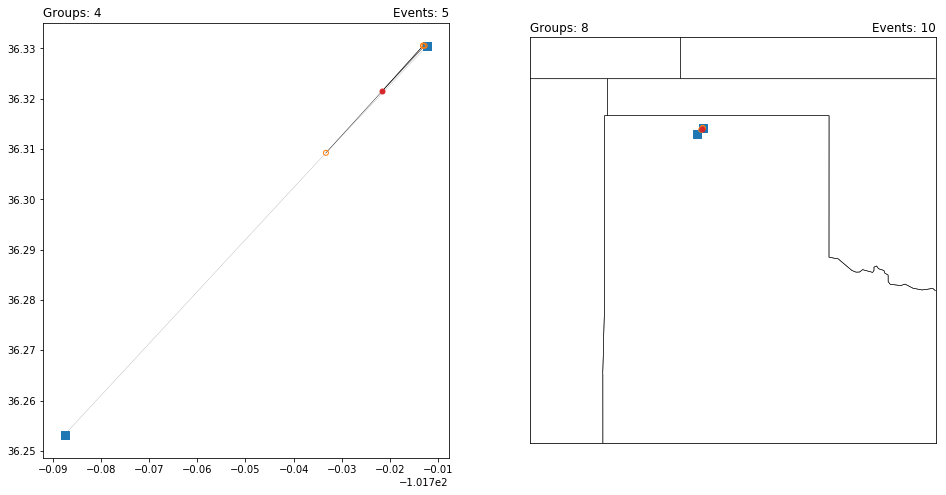

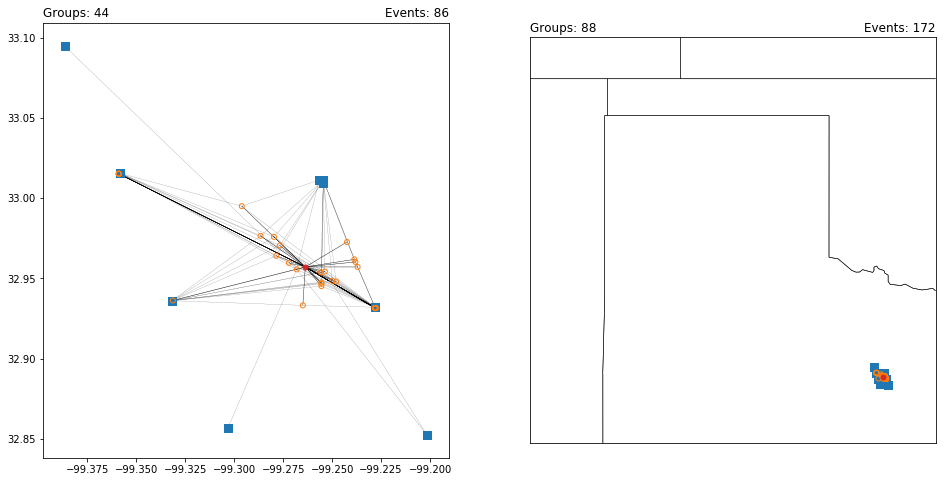

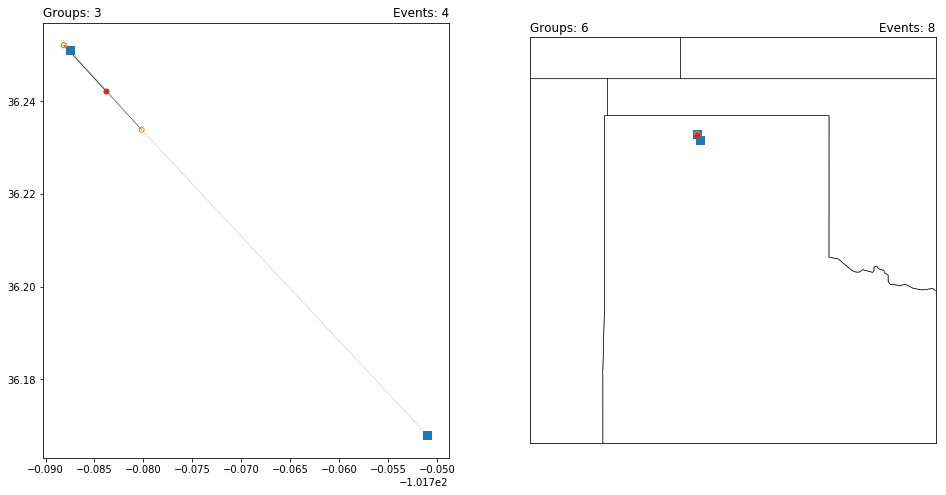

In [634]:
for i, point in enumerate([3, 4, 5, 6, 7]):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    
    point = slice(point, point+1)
    # Draw lines between event and group
    
    nGroups = 0
    nEvents = 0
    
    plt.sca(ax1)
    for F in list(FGE.keys())[point]:
        nGroups += len(FGE[F])
        for G in FGE[F]:
            nEvents += len(FGE[F][G])
            for E in FGE[F][G]:
                plt.plot([x.event_lon[E], x.group_lon[G]], [x.event_lat[E], x.group_lat[G]],
                         linewidth=.2, color='dimgrey')
                plt.scatter(x.event_lon[E], x.event_lat[E],
                            marker='s', color='tab:blue', s=50, zorder=5)

    # Draw lines between group and flash
    for F in list(FGE.keys())[point]:
        for G in FGE[F]:
            plt.plot([x.group_lon[G], x.flash_lon[F]], [x.group_lat[G], x.flash_lat[F]],
                     linewidth=.4, color='k')
            plt.scatter(x.group_lon[G], x.group_lat[G],
                        marker='o', facecolors='none', color='tab:orange', s=25, zorder=100000)
        plt.scatter(x.flash_lon[F], x.flash_lat[F], marker='.', s=100, c='tab:red', zorder=1000000)

    plt.title('Groups: %s' % nGroups, loc='left')
    plt.title('Events: %s' % nEvents, loc='right')
    
    
    plt.sca(ax2)
    for F in list(FGE.keys())[point]:
        nGroups += len(FGE[F])
        for G in FGE[F]:
            nEvents += len(FGE[F][G])
            for E in FGE[F][G]:
                plt.plot([x.event_lon[E], x.group_lon[G]], [x.event_lat[E], x.group_lat[G]],
                         linewidth=.2, color='dimgrey')
                plt.scatter(x.event_lon[E], x.event_lat[E],
                            marker='s', color='tab:blue', s=50, zorder=5)

    # Draw lines between group and flash
    for F in list(FGE.keys())[point]:
        for G in FGE[F]:
            plt.plot([x.group_lon[G], x.flash_lon[F]], [x.group_lat[G], x.flash_lat[F]],
                     linewidth=.4, color='k')
            plt.scatter(x.group_lon[G], x.group_lat[G],
                        marker='o', facecolors='none', color='tab:orange', s=25, zorder=100000)
        plt.scatter(x.flash_lon[F], x.flash_lat[F], marker='.', s=100, c='tab:red', zorder=1000000)

    plt.title('Groups: %s' % nGroups, loc='left')
    plt.title('Events: %s' % nEvents, loc='right')
    m.drawstates()

In [637]:
list(FGE.keys())[4]

26

In [639]:
len(FGE[26])

60

In [647]:
len(x.group_lon.data[list(FGE[26].keys())])

60

## Events over an hour

In [648]:
def get_GLM_events(DATE):
    # GLM Files for the hour
    GLM_files = get_GOES_nearesttime(DATE-timedelta(minutes=30),
                                     product='GLM', satellite=16, window=30, verbose=False)

    # GLM flash data from those files
    GLM_event = accumulate_GLM_FAST(GLM_files, data_type='event', verbose=False)

    # Boolean for flashes inside HRRR domain
    GLM_in_HRRR = filter_by_HRRR(GLM_event['latitude'], GLM_event['longitude'], lat, lon, mHRRR) 

    # Rewrite lightning flashes for only in HRRR domian
    GLM_event['longitude'] = GLM_event['longitude'][GLM_in_HRRR]
    GLM_event['latitude'] = GLM_event['latitude'][GLM_in_HRRR]
    return GLM_event

In [649]:
lat, lon = get_hrrr_latlon(DICT=False)
mHRRR = draw_HRRR_map()

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_i_2000.npy map from file


In [650]:
EVENT = get_fire('Mallard')

m = draw_centermap((EVENT['latitude'], EVENT['longitude']), size=(3.5, 3.5))

In [653]:
GLM = get_GLM_events(EVENT['event'])

Requested 2018-05-16 01:30:00	satellite: GOES-16	Product: GLM
-->> Accumulate GLM FAST MP: 90.0%

In [655]:
pairs = np.vstack([GLM['longitude'], GLM['latitude']])
uPairs, counts = np.unique(pairs, axis=1, return_counts=True)

np.shape(pairs), np.shape(uPairs)

((2, 2240687), (2, 33885))

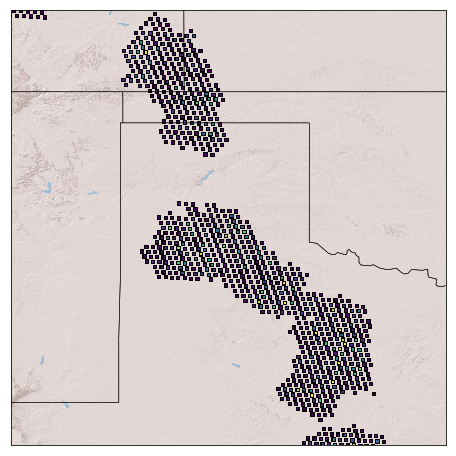

In [658]:
plt.figure(figsize=(8,8))
m.scatter(uPairs[0,:], uPairs[1,:],
          marker='s', edgecolor='k',
          c=counts, s=10, vmax=150, cmap='viridis', latlon=True)

m.drawstates()
m.arcgisimage(service='World_Shaded_Relief', xpixels=1000)